In [23]:
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt

def wrap_text(text, width=100):
    return textwrap.fill(
        text, 
        width=width,
        break_long_words=True,  # Разрывать длинные слова
        break_on_hyphens=False, # Не учитывать дефисы
        replace_whitespace=False
    )

## Вопросы и ответы
1. Соберите данные из источников. Укажите источники для каждого датасета, а также укажите, реальные они или синтетические.
- Источник описаний товаров - датасет walmart 2019ого года с кагла

2. Изучите данные, их структуру, оцените объем. Достаточно ли данных для создания вашего ML-решения? Объясните, почему. Если их недостаточно, опишите, где вы собираетесь их искать или собирать.
- Данных достаточно. Более 4000 товаров с описанием более 10 слов

3. Сделайте EDA, изучите качество данных и перечислите, какие в них есть проблемы, и опишите, как вы собираетесь с ними работать.
- Не все записи имеют достаточное описание (больше 10 слов). Мы будем считать, что требуем от описаний нормальную длину, поэтому все товары с описанием короче 10 слов мы обрезаем
- Некоторые записи имеют слишком длинные описания

4. Напишите свои выводы по итогам анализа: что нового узнали про данные, какие закономерности в них обнаружили,  как это отразится на выборе ML-подхода, как это поможет вам дальше в feature engineering’е и так далее.
- Данные норм, в процессе обучения модели будем уже делать преобразования со словами

In [26]:
df = pd.read_csv('walmart.csv')
df.head()

,Uniq Id,Crawl Timestamp,Product Url,Product Name,Description,List Price,Sale Price,Brand,Item Number,Gtin,Package Size,Category,Postal Code,Available
0,019b67ef7f01103d8fb0a53e4c36daa7,2019-12-18 10:20:52 +0000,https://www.walmart.com/ip/La-Costena-Chipotle...,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",We aim to show you accurate product informati...,31.93,31.93,La Costeï¿½ï¿½a,NaN,139941530,NaN,"Food | Meal Solutions, Grains & Pasta | Canned...",NaN,True
1,3a4ff306dcc8a6e2bf720964d29b84c3,2019-12-18 17:21:48 +0000,https://www.walmart.com/ip/Equate-Triamcinolon...,Equate Triamcinolone Acetonide Nasal Allergy S...,We aim to show you accurate product informati...,10.48,10.48,Equate,569045548.0,632775553,NaN,Health | Equate | Equate Allergy | Equate Sinu...,NaN,True
2,80090549d7d176327b186353c7b28ca4,2019-12-18 17:46:41 +0000,https://www.walmart.com/ip/AduroSmart-ERIA-Sof...,AduroSmart ERIA Soft White Smart A19 Light Bul...,We aim to show you accurate product informati...,10.99,10.99,AduroSmart ERIA,568068849.0,281487005,NaN,Electronics | Smart Home | Smart Energy and Li...,NaN,True
3,151ee1c61a29bacfedb01cd500494b2f,2019-12-18 22:14:22 +0000,https://www.walmart.com/ip/24-Classic-Adjustab...,"24"" Classic Adjustable Balloon Fender Set Chro...",We aim to show you accurate product informati...,38.59,38.59,lowrider,NaN,133714060,NaN,Sports & Outdoors | Bikes | Bike Accessories |...,NaN,True
4,7b2ef8d41f65df121f6b4b9828cf8dad,2019-12-18 06:56:02 +0000,https://www.walmart.com/ip/Elephant-Shape-Sili...,Elephant Shape Silicone Drinkware Portable Sil...,We aim to show you accurate product informati...,5.81,5.81,Anself,NaN,104042139,NaN,Baby | Feeding | Sippy Cups: Alternatives to P...,NaN,True


In [27]:
# Чекаем, что тут по категориям
df['Category'].apply(lambda x: list(map(lambda y: y.strip(), str(x).split('|')))).explode().value_counts().sort_values(ascending=False)

Category
Sports & Outdoors           11077
Food                         4141
Health                       3924
Sports                       3763
Outdoor Sports               2800
                            ...  
Cantu Styling Products          1
Mueller Knee Braces             1
K-Y Warming                     1
Antifungal Powders              1
Korean & Japanese Beauty        1
Name: count, Length: 4194, dtype: int64

In [53]:
pattern = r"Food|Meal"  # Берем для бэйзлайна все, что связано с едой
filtered_df = df[df["Category"].str.contains(pattern, case=False, na=False)]
filtered_df2 = filtered_df[['Uniq Id', 'Product Name', 'List Price', 'Category', 'Description']]
filtered_df2.head()

,Uniq Id,Product Name,List Price,Category,Description
0,019b67ef7f01103d8fb0a53e4c36daa7,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",31.93,"Food | Meal Solutions, Grains & Pasta | Canned...",We aim to show you accurate product informati...
5,e4fab4b6f41eac02d22b421818c8f080,(6 Boxes) Twinings of London Nightly Calm Gree...,17.99,Food | Beverages | Tea | All Tea,We aim to show you accurate product informati...
8,992c11a1b238eae6a2fabf22c74de5c2,"Tiny White Mighty Mints (16 oz, ZIN: 525424) -...",16.54,"Food | Chocolate, Candy & Gum | Mints | Shop A...",We aim to show you accurate product informati...
21,290970606fd82ac39534aa32b8b3b149,SweetGourmet Narrow Sesame Sticks | Lightly Sa...,12.99,"Food | Snacks, Cookies & Chips | Crackers | Sn...",We aim to show you accurate product informati...
23,21fee4394b9cc53bb6ddbe4235506a5c,"Health Warrior Chia Bar, Acai Berry, 25 G, Pac...",23.21,Health | Superfoods & Cleanses | Superfoods | ...,We aim to show you accurate product informati...


In [54]:
# Убираем преамбулу волмарта из описания
filtered_df2['clean_desc'] = filtered_df2['Description'].apply(lambda x: x.split('|')[1].lower())
filtered_df2.drop(columns=['Description'], inplace=True)
filtered_df2['clean_desc'].head(10)

/var/folders/fg/sk3cgfkj0034v4pgx0_v6xw00000gn/T/ipykernel_7090/3653288929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['clean_desc'] = filtered_df2['Description'].apply(lambda x: x.split('|')[1].lower())
/var/folders/fg/sk3cgfkj0034v4pgx0_v6xw00000gn/T/ipykernel_7090/3653288929.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2.drop(columns=['Description'], inplace=True)


0     la costena chipotle peppers, 7 oz (pack of 12)...
5     enojy one of your favorite tea flavors with th...
8     tiny white mighty mints (16 oz, zin: 525424): ...
21    narrow sesame sticks are fresh, crunchy and li...
23    health warrior chia bar, acai berry is packed ...
24    soft. delicious. nutritious. an american class...
32    with its delicious mixed berry flavor, natures...
33    toschi organic balsamic vinegar of modena - 16...
38    classic chewy licorice treat. these are made i...
44    product highlights * 6 bags per box * non-gmo,...
Name: clean_desc, dtype: object

In [55]:
filtered_df2['words_cnt'] = filtered_df2['clean_desc'].apply(lambda x: len(x.split()))
filtered_df2['symbols_cnt'] = filtered_df2['clean_desc'].apply(len)
filtered_df2['digits_cnt'] = filtered_df2['clean_desc'].apply(lambda x: sum(map(lambda y: y.isdigit(), x)))
filtered_df2

/var/folders/fg/sk3cgfkj0034v4pgx0_v6xw00000gn/T/ipykernel_7090/3074846403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['words_cnt'] = filtered_df2['clean_desc'].apply(lambda x: len(x.split()))
/var/folders/fg/sk3cgfkj0034v4pgx0_v6xw00000gn/T/ipykernel_7090/3074846403.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df2['symbols_cnt'] = filtered_df2['clean_desc'].apply(len)
/var/folders/fg/sk3cgfkj0034v4pgx0_v6xw00000gn/T/ipykernel_7090/3074846403.py:3: SettingWithCopyWarning

,Uniq Id,Product Name,List Price,Category,clean_desc,words_cnt,symbols_cnt,digits_cnt
0,019b67ef7f01103d8fb0a53e4c36daa7,"La Costena Chipotle Peppers, 7 OZ (Pack of 12)",31.93,"Food | Meal Solutions, Grains & Pasta | Canned...","la costena chipotle peppers, 7 oz (pack of 12)...",17,92,3
5,e4fab4b6f41eac02d22b421818c8f080,(6 Boxes) Twinings of London Nightly Calm Gree...,17.99,Food | Beverages | Tea | All Tea,enojy one of your favorite tea flavors with th...,111,615,8
8,992c11a1b238eae6a2fabf22c74de5c2,"Tiny White Mighty Mints (16 oz, ZIN: 525424) -...",16.54,"Food | Chocolate, Candy & Gum | Mints | Shop A...","tiny white mighty mints (16 oz, zin: 525424): ...",128,780,11
21,290970606fd82ac39534aa32b8b3b149,SweetGourmet Narrow Sesame Sticks | Lightly Sa...,12.99,"Food | Snacks, Cookies & Chips | Crackers | Sn...","narrow sesame sticks are fresh, crunchy and li...",64,411,5
23,21fee4394b9cc53bb6ddbe4235506a5c,"Health Warrior Chia Bar, Acai Berry, 25 G, Pac...",23.21,Health | Superfoods & Cleanses | Superfoods | ...,"health warrior chia bar, acai berry is packed ...",85,475,12
...,...,...,...,...,...,...,...,...
29982,fd0ee3971324039ab866d5532a5e27b2,"Rice select arborio rice, 36 oz, (pack of 4)",35.87,"Food | Meal Solutions, Grains & Pasta | Grains...","rice select arborio rice, 36 oz, (pack of 4)",9,44,3
29991,12a9c44b36ff56ce72cb59c8f7915f92,Biofinest Maqui Berry Juice Powder - 100% Pure...,14.95,Food | Beverages | Juices | All Juice,biofinest maqui berry juice powder - 100% pur...,62,400,8
29994,62519e68d65b1743163051aa1f621e60,Sheng Xiang Zhen (ShengXiangZhen) Snack + OneN...,45.99,"Food | Snacks, Cookies & Chips | Chips & Crisp...",sheng xiang zhen (shengxiangzhen) snack + onen...,16,96,1
29995,a471d7da9a2cb49dff316be704d2a0ae,McCain Smiles,0.00,Food | Frozen Foods | Frozen Vegetables,add a wholesome side to your dinnertime meal w...,201,1209,52


264


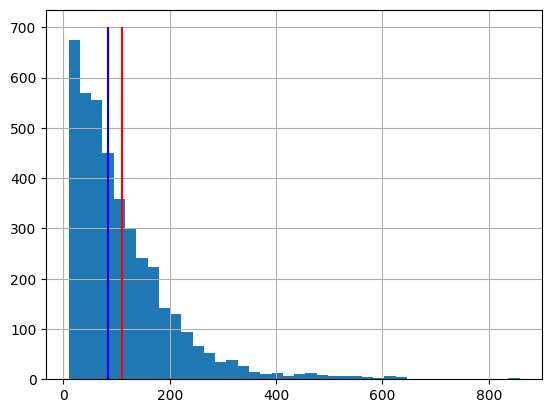

In [56]:
print(filtered_df2[filtered_df2['words_cnt'] < 10].shape[0]) #Сколько суперкоротких описаний, их выкинем
filtered_df3 = filtered_df2[filtered_df2['words_cnt'] >= 10]
filtered_df3['words_cnt'].hist(bins=40)
plt.vlines(
    [
        filtered_df3['words_cnt'].mean(),
        filtered_df3['words_cnt'].median(),
    ], 
    ymin=0,
    ymax=700,
    colors=['r', 'b']
)

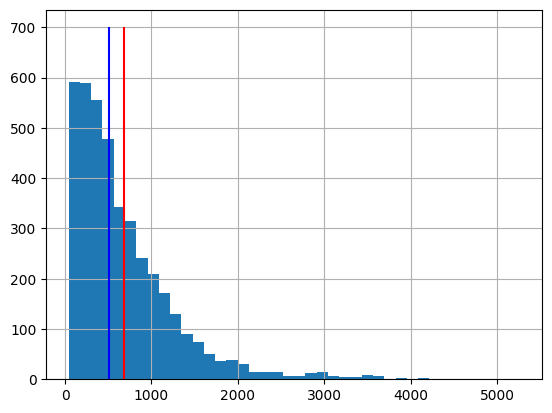

In [57]:
filtered_df3['symbols_cnt'].hist(bins=40)
plt.vlines(
    [
        filtered_df3['symbols_cnt'].mean(),
        filtered_df3['symbols_cnt'].median(),
    ], 
    ymin=0,
    ymax=700,
    colors=['r', 'b']
)

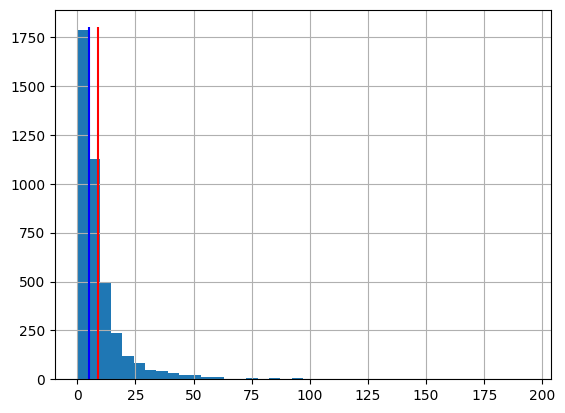

In [58]:
filtered_df3['digits_cnt'].hist(bins=40)
plt.vlines(
    [
        filtered_df3['digits_cnt'].mean(),
        filtered_df3['digits_cnt'].median(),
    ], 
    ymin=0,
    ymax=1800,
    colors=['r', 'b']
)

In [59]:
filtered_df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4070 entries, 0 to 29995
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Uniq Id       4070 non-null   object 
 1   Product Name  4070 non-null   object 
 2   List Price    4070 non-null   float64
 3   Category      4070 non-null   object 
 4   clean_desc    4070 non-null   object 
 5   words_cnt     4070 non-null   int64  
 6   symbols_cnt   4070 non-null   int64  
 7   digits_cnt    4070 non-null   int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 286.2+ KB


In [60]:
filtered_df3.describe()

,List Price,words_cnt,symbols_cnt,digits_cnt
count,4070.000000,4070.000000,4070.000000,4070.000000
mean,27.929339,111.072973,683.565111,9.010074
std,37.613961,97.934256,607.128300,12.258827
min,0.000000,10.000000,42.000000,0.000000
25%,8.575000,44.000000,267.000000,2.000000
50%,18.415000,84.000000,511.000000,5.000000
75%,35.465000,150.000000,916.250000,11.000000
max,1249.000000,858.000000,5259.000000,194.000000


In [72]:
# По словам и их встречаемости нифига не понятно, т.к. много слов без особого смысла. 
words = filtered_df3['clean_desc'].apply(lambda x: x.split()).explode().tolist()

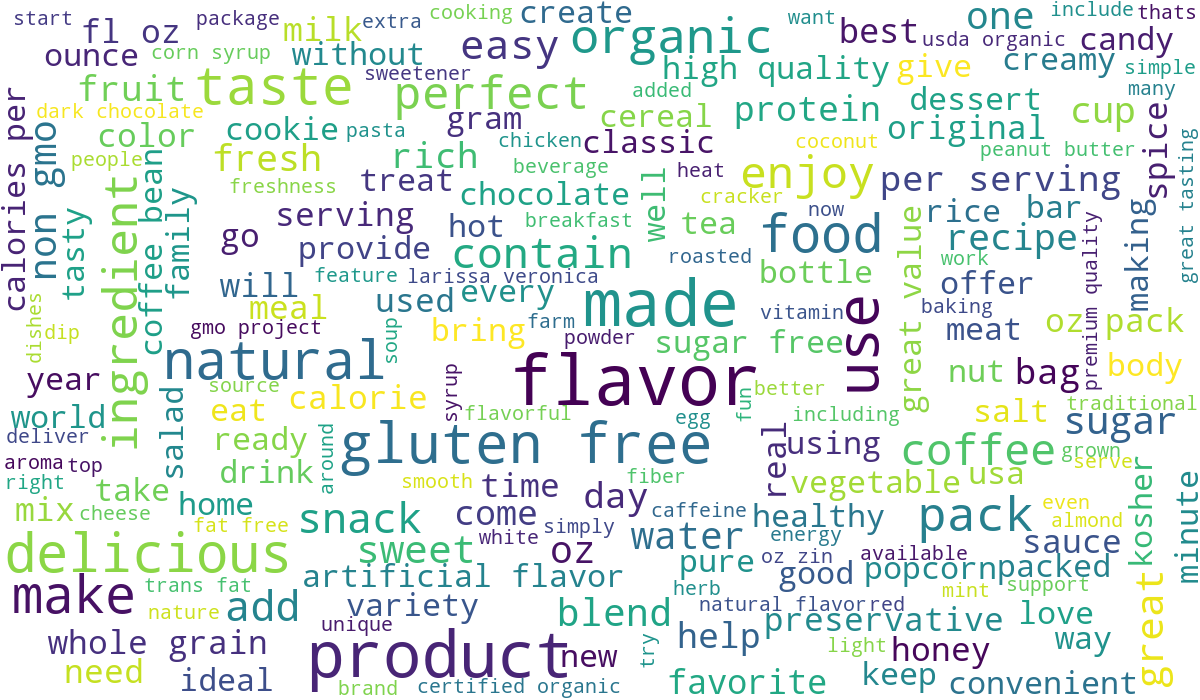

In [77]:
# Чекаем, какие тут осмысленные слова в описании вообще
from wordcloud import WordCloud

wc = WordCloud(max_font_size=70,
               max_words=200,
               background_color="white",
               stopwords=None,
               width=1200, height=700
               )

wc.generate(' '.join(words))
wc.to_image()